In [1]:
import math

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from typing import Tuple
import cv2

In [2]:
images = {
    "christmas_tree_6000x4000": "images/christmas_tree_6000x4000.png",
    "christmas_tree_600x400": "images/christmas_tree_600x400.png",
    "christmas_tree_194x129": "images/christmas_tree_194x129.png",
    "lenna_512x512": "images/lenna_512x512.png",
    "lenna_256x256": "images/lenna_256x256.png",
    "lenna_128x128": "images/lenna_128x128.png",
    "lenna_64x64": "images/lenna_64x64.png",
    "lenna_32x32": "images/lenna_32x32.png",
    "Barns_grand_tetons_1600x1195": "images/Barns_grand_tetons_1600x1195.png",
}


In [3]:
# image which should be encoded
image_path = images["christmas_tree_194x129"]

# jpeg parameters
block_size: int = 8
subsampling_settings: Tuple[int, int, int] = (4, 1, 0)
# subsampling_settings: Tuple[int, int, int] = (4, 4, 4)  # can be (4,4,4) (4,4,2)
quantization_table_quality: int = 100  # can be one of: (100, 90, 50, 10)

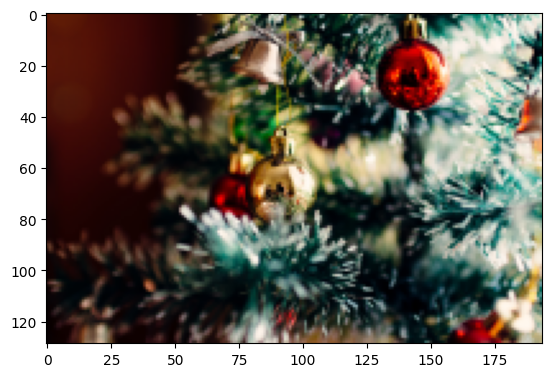

In [4]:
original_image = plt.imread(image_path)
original_image_resolution = tuple(reversed(original_image.shape[:2]))

# strip alpha channel if exists
if original_image.shape[2] == 4:
    channels = np.dsplit(original_image, 4)
    original_image = np.dstack(channels[:3])

fig, ax = plt.subplots()
ax.imshow(original_image, cmap="gray")

In [5]:
def plot_y_u_v(y_loc, u_loc, v_loc, colormap=True):
    fig_loc, ax_loc = plt.subplots(1, 3, figsize=(15, 20))
    ax_loc[0].imshow(y_loc, cmap="gray")
    ax_loc[0].set_title("Y Component")

    # creating a linear colormap, based on the values of the example https://commons.wikimedia.org/wiki/File:Barn-yuv.png
    if colormap:
        cmap_u = matplotlib.colors.LinearSegmentedColormap.from_list("", [(0, 177 / 255, 78 / 255, 1),
                                                                          (0, 86 / 255, 169 / 255, 1)])
    else:
        cmap_u = matplotlib.colormaps["gray"]
    ax_loc[1].imshow(u_loc, cmap=cmap_u)
    ax_loc[1].set_title("U Component")

    if colormap:
        cmap_v = matplotlib.colors.LinearSegmentedColormap.from_list("", [(104 / 255, 151 / 255, 0, 1),
                                                                          (171 / 255, 84 / 255, 0)])
    else:
        cmap_v = matplotlib.colormaps["gray"]
    ax_loc[2].imshow(v_loc, cmap=cmap_v)
    ax_loc[2].set_title("V Component")
    plt.show()

In [6]:
def get_matrix(size=8):
    matr = []
    for i in range(size):
        matr.append(np.array(range(i * size, (i + 1) * size)))
    matr = np.array(matr)
    print(matr)

## Step 1 
### Colorspace Transformation

In [7]:
from jpeg_implementation.rgbToYuv import rgb_to_yuv

In [8]:
y, u, v = rgb_to_yuv(image=original_image)

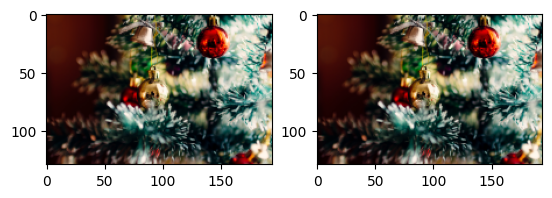

In [9]:
# def yuv_to_rgb2(y, u, v):
#     yuv = cv2.merge((y, u, v))
#     yuv = np.float32(yuv)
#     yuv /= 255
#     image = cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB)
#     return image * 255
#
from jpeg_implementation.rgbToYuv import yuv_to_rgb

image2 = yuv_to_rgb(y,u,v)
fig, ax = plt.subplots(1,2)
ax[0].imshow(original_image)
ax[1].imshow(image2/255)

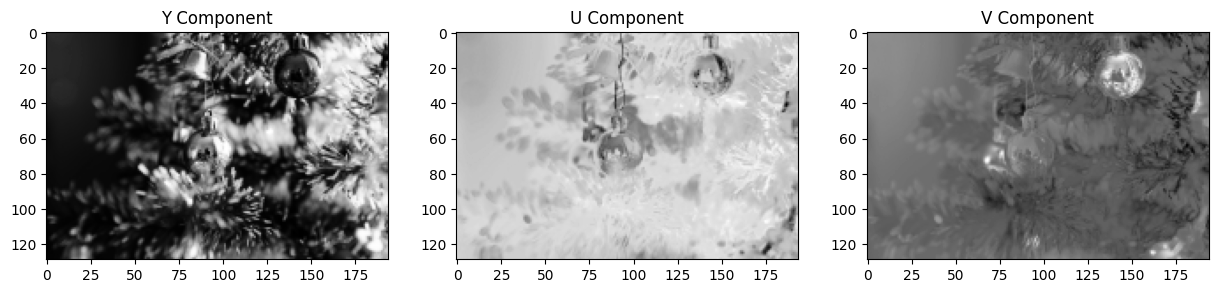

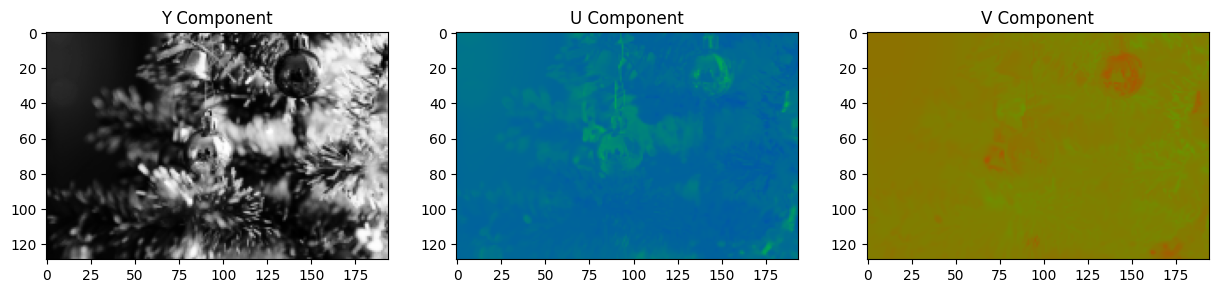

In [10]:
plot_y_u_v(y, u, v, colormap=False)
plot_y_u_v(y, u, v)


## Step 2 
### Subsampling of Color Components

In [11]:
from jpeg_implementation.subsample import subsample_u_v

In [12]:
u_subs, v_subs = subsample_u_v(u, v, *subsampling_settings)
print(len(y), len(u_subs), len(v_subs))
print(u_subs.shape)

129 65 65
(65, 49)


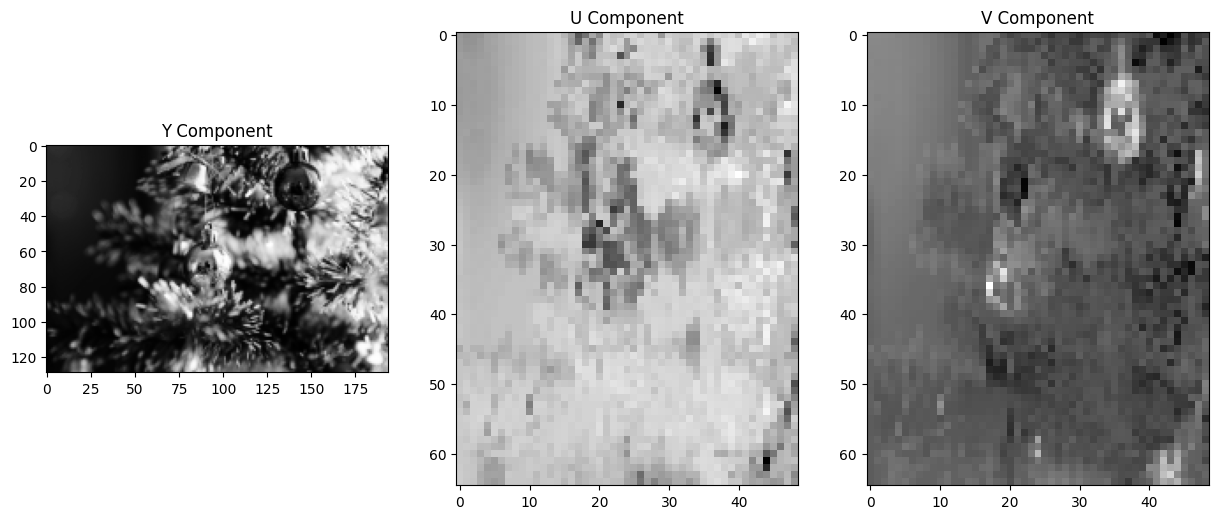

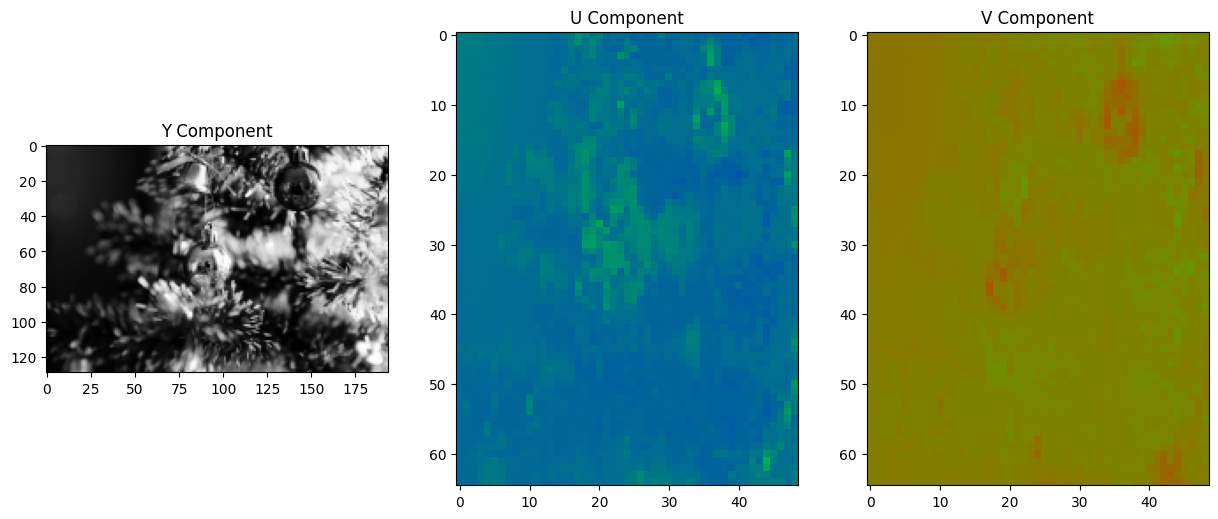

In [13]:
plot_y_u_v(y, u_subs, v_subs, colormap=False)
plot_y_u_v(y, u_subs, v_subs)


## Step 3
### Split into 8x8 Blocks

In [14]:
from jpeg_implementation.splitBlocks import split

In [15]:
split_y = split(y, block_size)
split_u = split(u_subs, block_size)
split_v = split(v_subs, block_size)

print(len(split_y), len(split_u), len(split_v))


425 63 63


[[41.693    46.895    46.895    45.71     45.71     45.71     45.71
  45.71    ]
 [41.682    45.71     47.009    45.824    45.237003 45.525    45.525
  45.525   ]
 [40.508    43.28     45.71     45.824    44.938    45.525    45.525
  44.938   ]
 [40.209003 42.095    43.867    45.525    45.639    44.753    44.639
  44.753   ]
 [39.91     41.209    41.796    42.981003 44.454002 44.753    45.226
  44.639   ]
 [39.024002 40.024002 40.91     41.796    41.91     42.981003 43.567997
  43.567997]
 [38.252    39.138    40.024002 40.611    40.91     41.796    41.496998
  42.383003]
 [39.138    38.839    38.953003 40.013    40.725002 40.91     40.91
  41.796   ]]


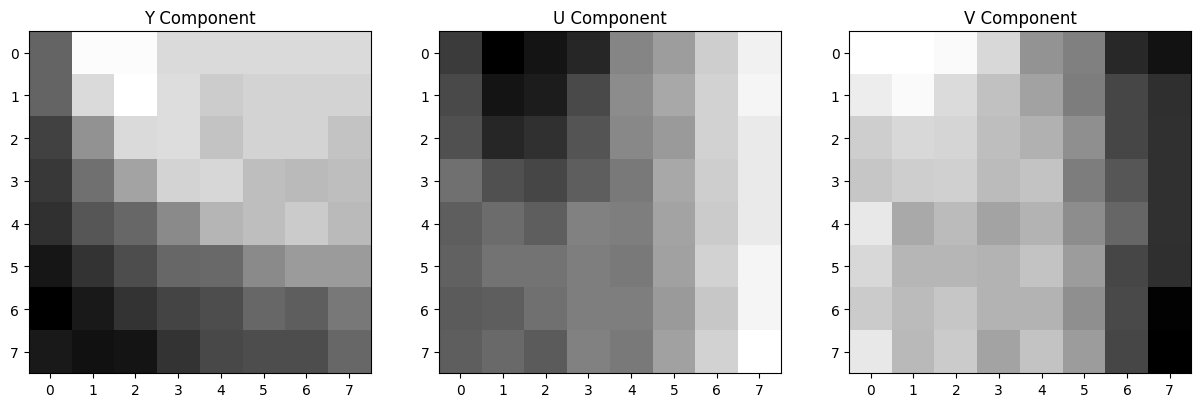

In [16]:
print(split_y[0])
plot_y_u_v(split_y[0], split_u[0], split_v[0], colormap=False)


## Step 3
### Apply dct

In [17]:
from jpeg_implementation.dct import block_dct2

In [18]:
trans_y = block_dct2(np.array(split_y) - 128, block_size)
trans_u = block_dct2(np.array(split_u) - 128, block_size)
trans_v = block_dct2(np.array(split_v) - 128, block_size)


## Step 4 
### Quantization


In [19]:
from jpeg_implementation.quantization import quantize, quantization_tables

quantization_table = quantization_tables[quantization_table_quality]

quantized_y = quantize(trans_y, quantization_table)
quantized_u = quantize(trans_u, quantization_table)
quantized_v = quantize(trans_v, quantization_table)

## Step 5
### Reordering of values, Run Length Encoding

In [20]:
from jpeg_implementation.runLengthEncode import resort_and_run_length_encode

In [21]:
rl_encoded_y = resort_and_run_length_encode(quantized_y, block_size)
rl_encoded_u = resort_and_run_length_encode(quantized_u, block_size)
rl_encoded_v = resort_and_run_length_encode(quantized_v, block_size)


In [22]:
print(len(rl_encoded_y), len(rl_encoded_u), len(rl_encoded_v))
print(rl_encoded_u[0])
print(rl_encoded_v[0])

47598 7128 7556
-120.0
318.0


## Step 6
### Huffman Encoding

In [23]:
from jpeg_implementation.huffman import generate_huffman_code, encode_huffman

data = rl_encoded_y + rl_encoded_u + rl_encoded_v
huffman_code = generate_huffman_code(data)
encoded = encode_huffman(huffman_code, data)
print("original", len(data * 8), "bits")
print("encoded", len(encoded), "bits")
print("encoded + table", len(encoded) + len(huffman_code) * 16, "bits")
print("compression ratio", len(data * 8) / len(encoded))

original 498256 bits
encoded 257329 bits
encoded + table 270865 bits
compression ratio 1.9362605846989651


In [24]:
huffman_code_y = generate_huffman_code(rl_encoded_y)
huff_encoded_y = encode_huffman(huffman_code_y, rl_encoded_y)

huffman_code_u = generate_huffman_code(rl_encoded_u)
huff_encoded_u = encode_huffman(huffman_code_u, rl_encoded_u)

huffman_code_v = generate_huffman_code(rl_encoded_v)
huff_encoded_v = encode_huffman(huffman_code_v, rl_encoded_v)

print("y", len(huff_encoded_y), "bits")
print("u", len(huff_encoded_u), "bits")
print("v", len(huff_encoded_v), "bits")
print("encoded", len(huff_encoded_y) + len(huff_encoded_u) + len(huff_encoded_v), "bits")
print("compression ratio", len(data * 8) / (len(huff_encoded_y) + len(huff_encoded_u) + len(huff_encoded_v)))

y 202521 bits
u 23724 bits
v 28820 bits
encoded 255065 bits
compression ratio 1.9534471605277086


## Step 7
### Serialization

In [25]:
from jpeg_implementation.serialize import store_as_file

file_size = store_as_file("test.data", huffman_code_y, huffman_code_u, huffman_code_v, huff_encoded_y, huff_encoded_u,
                          huff_encoded_v)
print(file_size)
print(len(data) / file_size)

43144
1.443584275913221


In [26]:
# calculate effective compression ratio
import os

original_size = os.path.getsize(image_path)
compression_ratio = original_size / file_size
print("Effective Compression Ratio:", compression_ratio, "(Compared to PNG file)")

Effective Compression Ratio: 1.4952252920452438 (Compared to PNG file)


## Step 8
### Deserialization

In [27]:
from jpeg_implementation.serialize import read_from_file

huffman_code_y, huffman_code_u, huffman_code_v, huff_encoded_y, huff_encoded_u, huff_encoded_v = read_from_file(
    "test.data")


## Step 9
### Decode Huffman

In [28]:
from jpeg_implementation.huffman import decode_huffman

rl_encoded_y = decode_huffman(huff_encoded_y, huffman_code_y)
rl_encoded_u = decode_huffman(huff_encoded_u, huffman_code_u)
rl_encoded_v = decode_huffman(huff_encoded_v, huffman_code_v)



## Step 10
### Decode run-length encoding + Reordering of values

In [29]:
from jpeg_implementation.runLengthEncode import unsort_and_run_length_decode

y_blocks = unsort_and_run_length_decode(rl_encoded_y, block_size)
u_blocks = unsort_and_run_length_decode(rl_encoded_u, block_size)
v_blocks = unsort_and_run_length_decode(rl_encoded_v, block_size)


## Step 11
### Apply inverse DCT

(425, 8, 8)
(63, 8, 8)
y (129, 194)
u (129, 194)


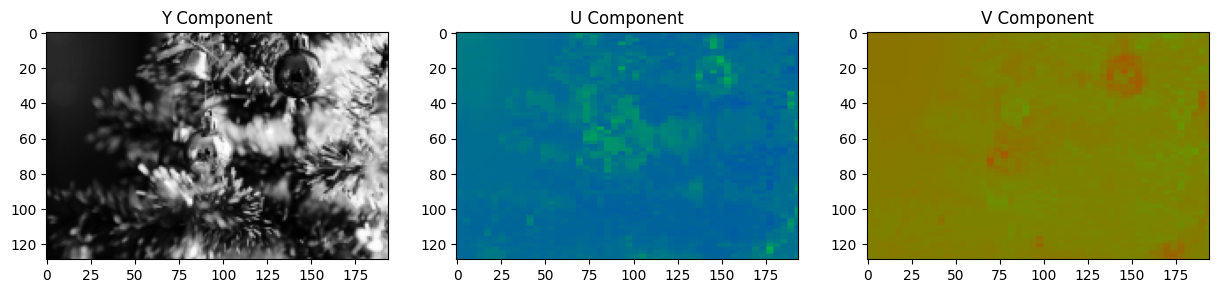

In [30]:
from jpeg_implementation.quantization import quantize_inverse
from jpeg_implementation.dct import block_idct2
from jpeg_implementation.splitBlocks import merge_blocks
from jpeg_implementation.subsample import up_sample_u_v
from jpeg_implementation.subsample import calculate_down_sampled_resolution

iq_y = quantize_inverse(y_blocks, quantization_table)
iq_u = quantize_inverse(u_blocks, quantization_table)
iq_v = quantize_inverse(v_blocks, quantization_table)

id_y = block_idct2(iq_y, block_size) + 128
id_u = block_idct2(iq_u, block_size) + 128
id_v = block_idct2(iq_v, block_size) + 128

print(id_y.shape)
print(id_u.shape)


downsampled_resolution = calculate_down_sampled_resolution(*subsampling_settings, original_image_resolution)

compressed_y = merge_blocks(id_y, original_image_resolution, block_size)
compressed_u = merge_blocks(id_u, downsampled_resolution, block_size)
compressed_v = merge_blocks(id_v, downsampled_resolution, block_size)


compressed_u, compressed_v = up_sample_u_v(compressed_u,compressed_v, *subsampling_settings, original_image_resolution)

print("y",compressed_y.shape)
print("u",compressed_u.shape)

plot_y_u_v(compressed_y,compressed_u,compressed_v)



In [31]:
print(np.max(compressed_y))
print(np.max(compressed_u))
print(np.max(compressed_v))

print(np.min(compressed_y))
print(np.min(compressed_u))
print(np.min(compressed_v))

print(np.max(y))
print(np.max(u))
print(np.max(v))

print(np.min(y))
print(np.min(u))
print(np.min(v))


251.09408829630462
144.51206348460548
280.4193659526466
-0.5504107992979925
59.6641163162284
46.029134618069094
250.69699
144.63045
280.57947
0.0
46.241768
33.7943


-104 356


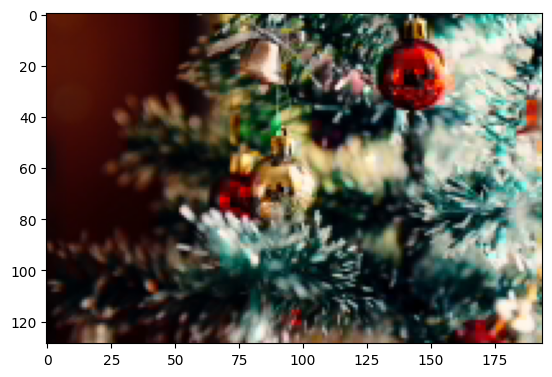

In [32]:
from jpeg_implementation.rgbToYuv import yuv_to_rgb

reconstructed_image = yuv_to_rgb(compressed_y,compressed_u, compressed_v)

print(np.min(reconstructed_image), np.max(reconstructed_image))

reconstructed_image = reconstructed_image.astype(int)
reconstructed_image = reconstructed_image.clip(0,255)

fig, ax = plt.subplots()
ax.imshow(reconstructed_image)

# plt.axis('off')
# plt.savefig("compressed.png", bbox_inches='tight', pad_inches=0, dpi=300)

plt.imsave("compressed.png", reconstructed_image.astype(np.uint8))
plt.show()

original_image 0 255
reconstructed_image 0 255
diff 0 161


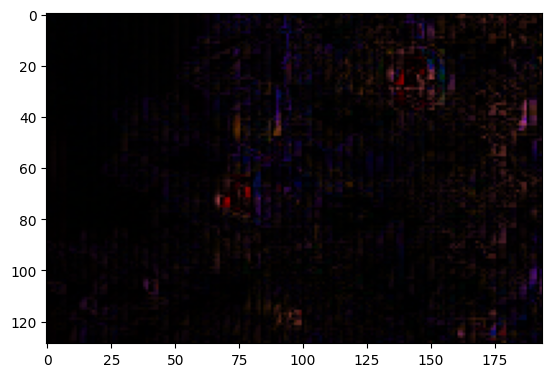

In [33]:
# res = np.dstack([reconstructed_image, np.zeros(512**2).reshape(512,512)])
original_image_rescaled = original_image * 255
original_image_rescaled = original_image_rescaled.astype(int)
diff = np.abs(original_image_rescaled - reconstructed_image)

print("original_image",np.min(original_image_rescaled), np.max(original_image_rescaled))
print("reconstructed_image",np.min(reconstructed_image), np.max(reconstructed_image))

white = np.zeros(512**2*3).reshape((512,512,3)) + 254

# diff2 = 255 - diff
print("diff", np.min(diff), np.max(diff))
# print("diff2", np.min(diff2), np.max(diff2))

fig, ax = plt.subplots()
ax.imshow(diff)
plt.show()


diff2 0 255


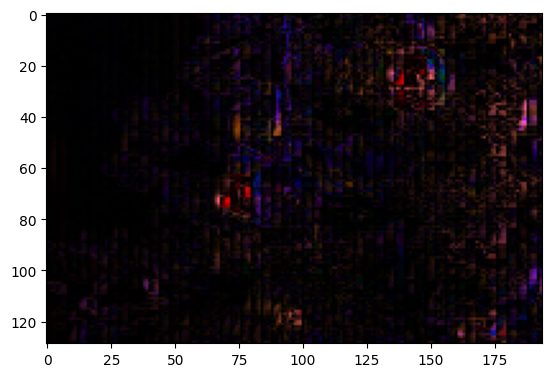

In [34]:
# extrapolate differences for better visualisation
diff2 = diff * (255/np.max(diff))
# diff2 = (diff2* -1) + 255

diff2 = diff2.astype(int)
print("diff2", np.min(diff2), np.max(diff2))

fig, ax = plt.subplots()
ax.imshow(diff2)
plt.show()
